In [1]:
import kagglehub
paramaggarwal_fashion_product_images_dataset_path = kagglehub.dataset_download('paramaggarwal/fashion-product-images-dataset')
print('Successfully Imported dataset')

Successfully Imported dataset


In [2]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import glob
import pickle
import warnings
warnings.filterwarnings('ignore')  #importing all the Required Libraries

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# Configuration settings
class Config:
    DATA_DIR = '/kaggle/input/fashion-product-images-dataset/fashion-dataset'
    IMG_DIR = os.path.join(DATA_DIR, 'images')
    CSV_PATH = os.path.join(DATA_DIR, 'styles.csv')
    IMG_SIZE = 128
    BATCH_SIZE = 64
    EPOCHS = 3
    LEARNING_RATE = 1e-3
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# 1. Data Loading and Preprocessing
def load_and_preprocess_data():

    # Load metadata
    df = pd.read_csv(Config.CSV_PATH, on_bad_lines='skip')

    # Create image paths
    df['image_path'] = df['id'].apply(lambda x: os.path.join(Config.IMG_DIR, f"{x}.jpg"))

    # Remove rows with missing values in required columns
    required_columns = ['baseColour', 'articleType', 'season', 'gender']
    df = df.dropna(subset=required_columns)

    # Filter rows where images exist
    df = df[df['image_path'].apply(os.path.exists)]

    return df

In [6]:
# 2. Exploratory Data Analysis (EDA)
def perform_eda(df):

    print("Dataset Shape:", df.shape)
    print("\nMissing Values:\n", df.isnull().sum())

    # Plot distributions of categorical variables
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.countplot(data=df, x='gender')
    plt.title('Gender Distribution')

    plt.subplot(2, 2, 2)
    sns.countplot(data=df, x='season')
    plt.title('Season Distribution')

    plt.subplot(2, 2, 3)
    sns.countplot(data=df, x='baseColour')
    plt.title('Color Distribution')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 4)
    sns.countplot(data=df, x='articleType')
    plt.title('Product Type Distribution')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Display sample images
    plt.figure(figsize=(15, 5))
    sample_df = df.sample(5)
    for i, row in enumerate(sample_df.itertuples()):
        plt.subplot(1, 5, i+1)
        img = Image.open(row.image_path)
        plt.imshow(img)
        plt.title(f"{row.baseColour}\n{row.articleType}")
        plt.axis('off')
    plt.show()

In [7]:
!pip install -q ydata-profiling #Installing pandas profiling for EDA
from ydata_profiling import ProfileReport

In [8]:
# Replace this with your actual CSV path in Colab
CSV_PATH = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv'

# Load the CSV (skip bad lines)
df = pd.read_csv(CSV_PATH, on_bad_lines='skip')

# Droping rows with missing required columns
required_columns = ['baseColour', 'articleType', 'season', 'gender']
df = df.dropna(subset=required_columns)

#Generating the profile report
profile = ProfileReport(df, title="Fashion Dataset EDA Report", explorative=True)

# Display inside Colab notebook
profile.to_notebook_iframe()

#  Saving file
profile.to_file("fashion_eda_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# 3. Data Preparation
def prepare_data(df):
    """Prepare data by encoding labels and splitting dataset"""
    # Initialize label encoders
    le_colour = LabelEncoder()
    le_product_type = LabelEncoder()
    le_season = LabelEncoder()
    le_gender = LabelEncoder()

    # Encode categorical variables
    df['colour_label'] = le_colour.fit_transform(df['baseColour'])
    df['product_type_label'] = le_product_type.fit_transform(df['articleType'])
    df['season_label'] = le_season.fit_transform(df['season'])
    df['gender_label'] = le_gender.fit_transform(df['gender'])

    # Filter out product types with only one sample
    product_type_counts = df['product_type_label'].value_counts()
    to_remove = product_type_counts[product_type_counts < 2].index
    df = df[~df['product_type_label'].isin(to_remove)]

    # Split dataset
    train_df, test_df = train_test_split(df, test_size=0.1, random_state=42,
                                       stratify=df['product_type_label'])
    train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42,
                                      stratify=train_df['product_type_label'])

    return train_df, val_df, test_df, {
        'colour': le_colour,
        'product_type': le_product_type,
        'season': le_season,
        'gender': le_gender
    }

In [10]:
# 4. Custom Dataset
class FashionDataset(Dataset):
    """Custom PyTorch dataset for fashion products"""
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('RGB')

        if self.transform:
            img = self.transform(img)

        labels = {
            'colour': row['colour_label'],
            'product_type': row['product_type_label'],
            'season': row['season_label'],
            'gender': row['gender_label']
        }
        return img, labels

In [11]:
# 5. Model Definition
class MultiOutputModel(nn.Module):
    """Multi-output CNN model for fashion product classification"""
    def __init__(self, n_colours, n_product_types, n_seasons, n_genders):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()

        # Output layers for each classification task
        self.fc_colour = nn.Linear(512, n_colours)
        self.fc_product_type = nn.Linear(512, n_product_types)
        self.fc_season = nn.Linear(512, n_seasons)
        self.fc_gender = nn.Linear(512, n_genders)

    def forward(self, x):
        features = self.backbone(x)
        return {
            'colour': self.fc_colour(features),
            'product_type': self.fc_product_type(features),
            'season': self.fc_season(features),
            'gender': self.fc_gender(features)
        }

In [12]:
# 6. Training Functions
def train_one_epoch(model, loader, optimizer, criterion, device):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(loader, desc="Training"):
        imgs = imgs.to(device)
        targets = {k: torch.tensor(v).to(device) for k, v in labels.items()}

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = sum(criterion(outputs[k], targets[k]) for k in outputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

def evaluate(model, loader, criterion, device):
    """Evaluate model performance"""
    model.eval()
    running_loss = 0.0
    correct = {k: 0 for k in ['colour', 'product_type', 'season', 'gender']}
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(device)
            targets = {k: torch.tensor(v).to(device) for k, v in labels.items()}
            outputs = model(imgs)

            loss = sum(criterion(outputs[k], targets[k]) for k in outputs)
            running_loss += loss.item()

            for k in outputs:
                preds = outputs[k].argmax(1)
                correct[k] += (preds == targets[k]).sum().item()
            total += imgs.size(0)

    accuracies = {k: correct[k]/total for k in correct}
    return running_loss / len(loader), accuracies

In [13]:
# 7. Inference Function
def predict_image(img_path, model, transform, label_encoders, device):
    """Predict attributes for a single image"""
    img = Image.open(img_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img)
        predictions = {
            'colour': label_encoders['colour'].inverse_transform([outputs['colour'].argmax(1).item()])[0],
            'product_type': label_encoders['product_type'].inverse_transform([outputs['product_type'].argmax(1).item()])[0],
            'season': label_encoders['season'].inverse_transform([outputs['season'].argmax(1).item()])[0],
            'gender': label_encoders['gender'].inverse_transform([outputs['gender'].argmax(1).item()])[0]
        }
    return predictions

Loading and preprocessing data...
Performing EDA...
Dataset Shape: (44383, 11)

Missing Values:
 id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour              0
season                  0
year                    0
usage                 309
productDisplayName      2
image_path              0
dtype: int64


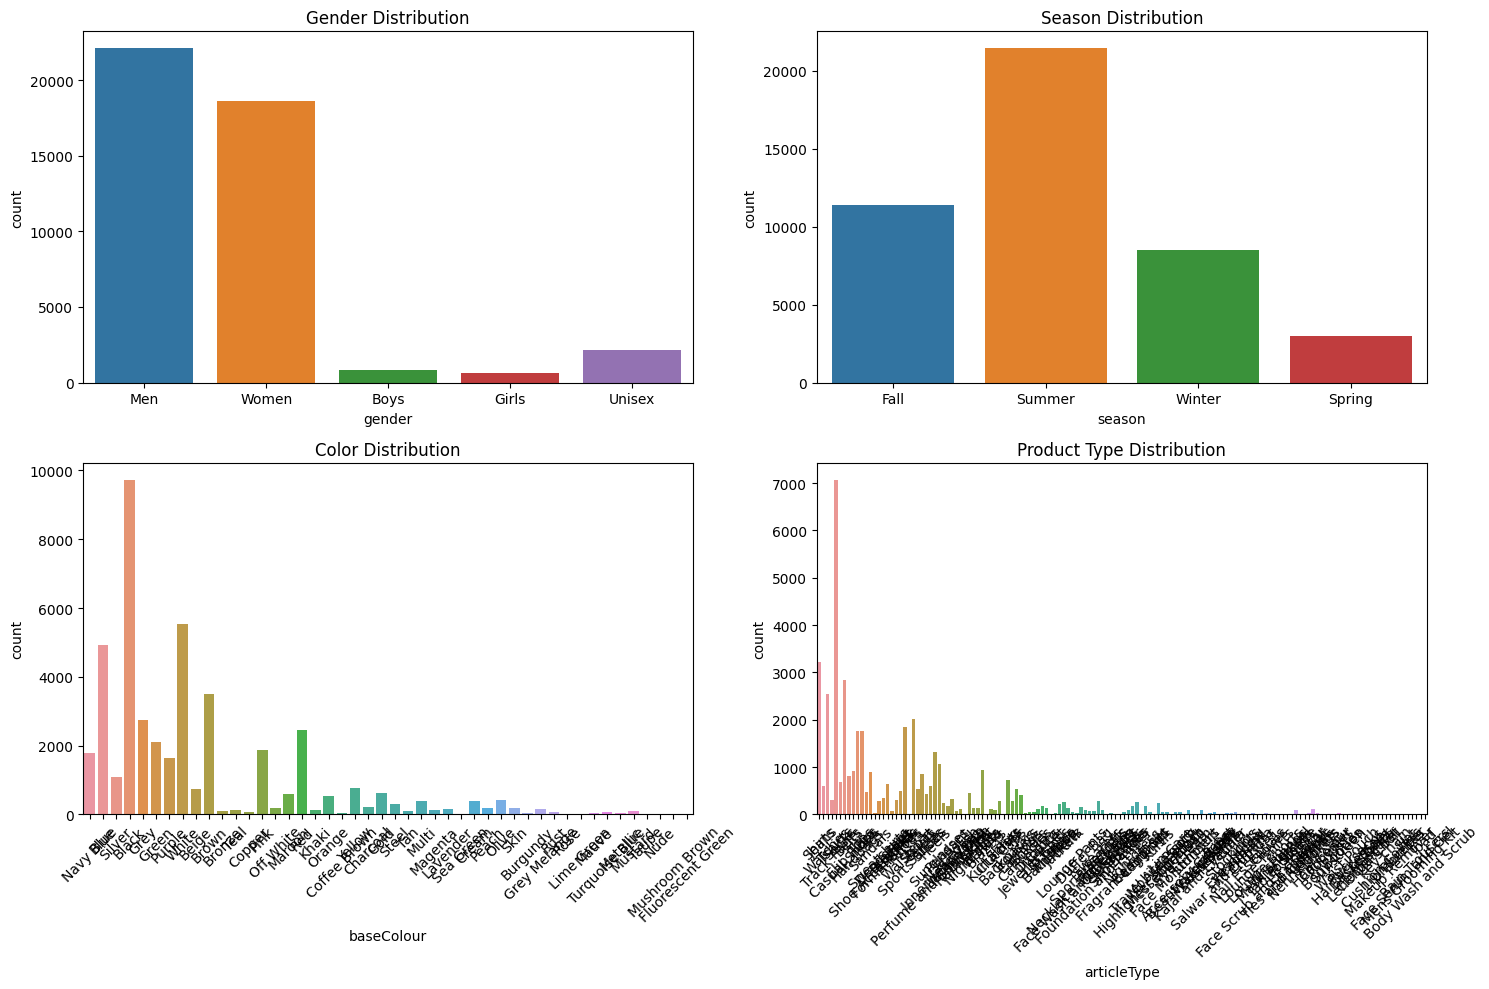

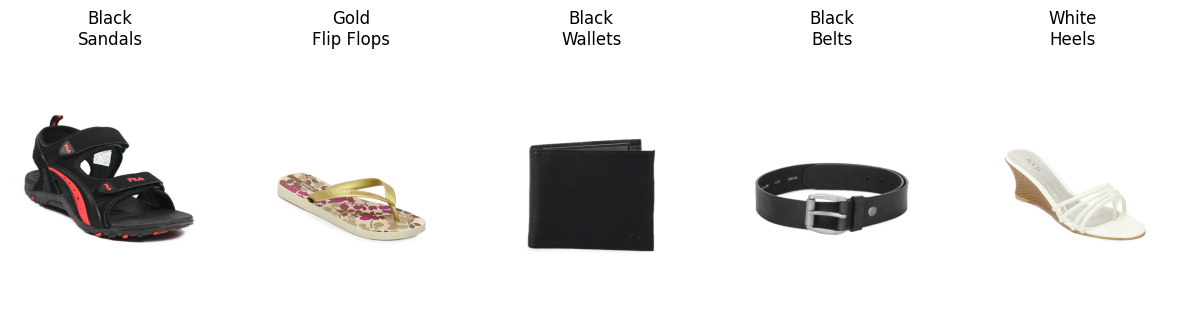

Preparing data...
Creating datasets and dataloaders...
Initializing model...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.3MB/s]


Training model...


Evaluating: 100%|██████████| 63/63 [02:04<00:00,  1.97s/it]


Epoch 1/3
Train Loss: 3.5615
Val Loss: 2.8650
Val Acc: {'colour': 0.628943415122684, 'product_type': 0.799949924887331, 'season': 0.7160741111667501, 'gender': 0.8963445167751627}


Evaluating: 100%|██████████| 63/63 [02:04<00:00,  1.98s/it]


Epoch 2/3
Train Loss: 2.6388
Val Loss: 2.7289
Val Acc: {'colour': 0.6627441161742614, 'product_type': 0.8127190786179269, 'season': 0.6952929394091136, 'gender': 0.9026039058587881}


Evaluating: 100%|██████████| 63/63 [02:06<00:00,  2.01s/it]


Epoch 3/3
Train Loss: 2.2813
Val Loss: 2.6958
Val Acc: {'colour': 0.6562343515272909, 'product_type': 0.8357536304456685, 'season': 0.7220831246870305, 'gender': 0.8978467701552328}
Evaluating on test set...


Evaluating: 100%|██████████| 70/70 [02:36<00:00,  2.24s/it]


Test Loss: 2.7166
Test Acc: {'colour': 0.6484903109508787, 'product_type': 0.8418206399278955, 'season': 0.7203695358269491, 'gender': 0.9022082018927445}
Saving model and encoders...
Performing inference on Amazon images...


In [14]:
# 8. Pipeline
def run_pipeline():
    """Complete pipeline for fashion product classification"""
    # Step 1: Load and preprocess data
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data()

    # Step 2: Perform EDA
    print("Performing EDA...")
    perform_eda(df)

    # Step 3: Prepare data
    print("Preparing data...")
    train_df, val_df, test_df, label_encoders = prepare_data(df)

    # Step 4: Create datasets and dataloaders
    print("Creating datasets and dataloaders...")
    transform = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_ds = FashionDataset(train_df, transform=transform)
    val_ds = FashionDataset(val_df, transform=transform)
    test_ds = FashionDataset(test_df, transform=transform)

    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2)

    # Step 5: Initialize model
    print("Initializing model...")
    model = MultiOutputModel(
        n_colours=len(label_encoders['colour'].classes_),
        n_product_types=len(label_encoders['product_type'].classes_),
        n_seasons=len(label_encoders['season'].classes_),
        n_genders=len(label_encoders['gender'].classes_)
    ).to(Config.DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

    # Step 6: Train model
    print("Training model...")
    best_val_loss = np.inf
    for epoch in range(Config.EPOCHS):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, Config.DEVICE)
        val_loss, val_acc = evaluate(model, val_loader, criterion, Config.DEVICE)

        print(f'Epoch {epoch+1}/{Config.EPOCHS}')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Val Acc: {val_acc}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    # Step 7: Evaluate on test set
    print("Evaluating on test set...")
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = evaluate(model, test_loader, criterion, Config.DEVICE)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Acc: {test_acc}')

    # Step 8: Save model and encoders
    print("Saving model and encoders...")
    torch.save(model.state_dict(), 'best_model.pth')
    for key, encoder in label_encoders.items():
        with open(f'le_{key}.pkl', 'wb') as f:
            pickle.dump(encoder, f)

    # Step 9: Inference on Amazon images
    print("Performing inference on Amazon images...")
    sample_imgs = glob.glob('amazon_samples/*.jpg')
    for img_path in sample_imgs:
        preds = predict_image(img_path, model, transform, label_encoders, Config.DEVICE)
        img = Image.open(img_path)
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Predictions:\n{preds}")
        plt.axis('off')
        plt.show()

# Run the pipeline
if __name__ == "__main__":
    run_pipeline()